In [1]:
import sys, os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from skimage.exposure import equalize_adapthist
import numpy as np
from pydicom import dcmread

sys.path.insert(0, "\\".join(os.path.abspath(os.curdir).split("\\")[:-2:]))
from src.utils.utils import load_inbreast_mask

## Testes de processamento de imagens

### MIAS

##### Variáveis base

In [2]:
df_mias = pd.read_csv('../../outputs/mamografia/mias/metadata_mias.csv')

IDX_MIAS = 28

IMAGE_MIAS = cv2.imread(df_mias['image_path'][IDX_MIAS], cv2.IMREAD_GRAYSCALE)
ROI_IMAGE_MIAS = cv2.imread(df_mias['roi_image_path'][IDX_MIAS], cv2.IMREAD_GRAYSCALE)

CROPPED_IMAGE_MIAS = IMAGE_MIAS[:, :-250]
CROPPED_IMAGE_MIAS = CROPPED_IMAGE_MIAS[:, 250:]

X_MIAS, Y_MIAS = int(df_mias['x_center_abnormality'][IDX_MIAS]), 1024 - int(df_mias['y_center_abnormality'][IDX_MIAS])
RADIUS_MIAS = int(df_mias['radius'][IDX_MIAS])
PATHOLOGY_MIAS = df_mias['pathology'][IDX_MIAS]

##### Equalização de histograma

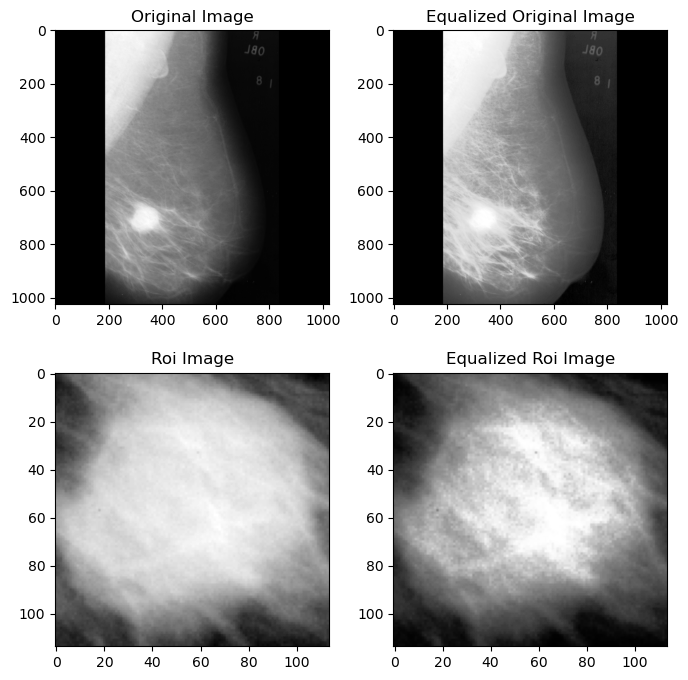

In [3]:
equalized_image = cv2.equalizeHist(IMAGE_MIAS)
equalized_roi_image = cv2.equalizeHist(ROI_IMAGE_MIAS)

images = [IMAGE_MIAS, equalized_image, ROI_IMAGE_MIAS, equalized_roi_image]
titles = ['Original Image', 'Equalized Original Image', 'Roi Image', 'Equalized Roi Image']

plt.figure(figsize=(8, 8))
for i in range(len(images)):
    plt.subplot(2, 2, i + 1)
    plt.title(titles[i])
    plt.imshow(images[i], cmap='gray')

plt.subplots_adjust(hspace = 0.25)
plt.show()

##### Clahe

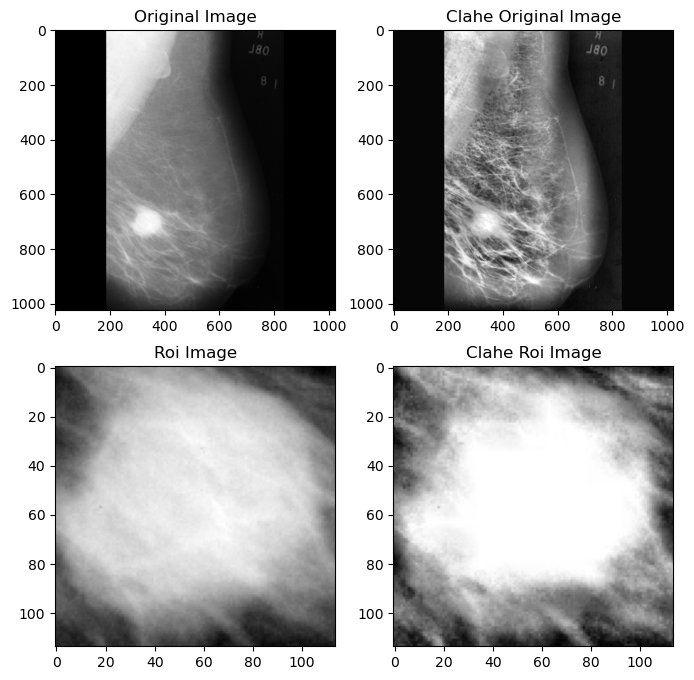

In [4]:
clahe_image = equalize_adapthist(IMAGE_MIAS, clip_limit=0.03)
clahe_roi_image = equalize_adapthist(ROI_IMAGE_MIAS, clip_limit=0.03)
#image_clahe = cv2.createCLAHE(clipLimit=6, tileGridSize=(8, 8)).apply(IMAGE_CROPPED)
#image_roi_clahe = cv2.createCLAHE(clipLimit=6, tileGridSize=(8, 8)).apply(IMAGE_ROI)

clahe_image = clahe_image * 255
clahe_roi_image = clahe_roi_image * 255
clahe_roi_image = clahe_roi_image.astype(np.uint8)

images = [IMAGE_MIAS, clahe_image, ROI_IMAGE_MIAS, clahe_roi_image]
titles = ['Original Image', 'Clahe Original Image', 'Roi Image', 'Clahe Roi Image']

plt.figure(figsize=(8, 8))
for i in range(len(images)):
    plt.subplot(2, 2, i + 1)
    plt.title(titles[i])
    plt.imshow(images[i], cmap='gray')

# Adiciona margem entre as subplots
plt.subplots_adjust(hspace = 0.2)
plt.show()

##### Segmentação

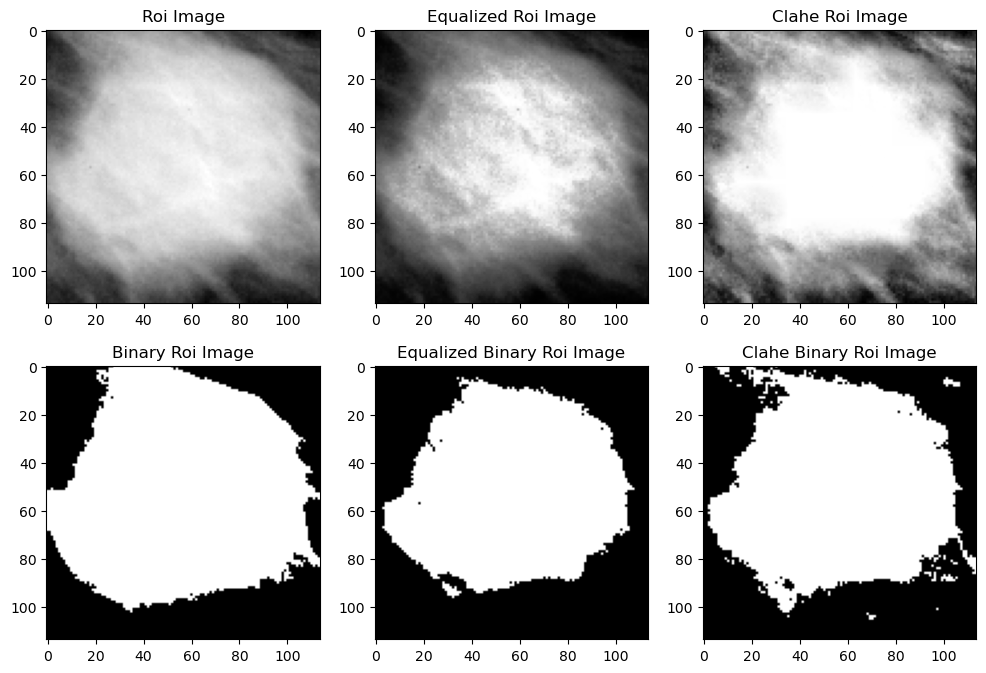

In [5]:
equalized_binary_image = cv2.threshold(equalized_roi_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
binary_image = cv2.threshold(ROI_IMAGE_MIAS, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
clahe_binary_image = cv2.threshold(clahe_roi_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

images = [ROI_IMAGE_MIAS, equalized_roi_image, clahe_roi_image,
          binary_image, equalized_binary_image, clahe_binary_image]
titles = ['Roi Image', 'Equalized Roi Image', 'Clahe Roi Image',
          'Binary Roi Image', 'Equalized Binary Roi Image', 'Clahe Binary Roi Image']

plt.figure(figsize=(12, 8))
for i in range(len(images)):
    plt.subplot(2, 3, i + 1)
    plt.title(titles[i])
    plt.imshow(images[i], cmap='gray')

# Adiciona margem entre as subplots
plt.subplots_adjust(hspace = 0.2)
plt.show()

##### Visualizar localização da anomalia

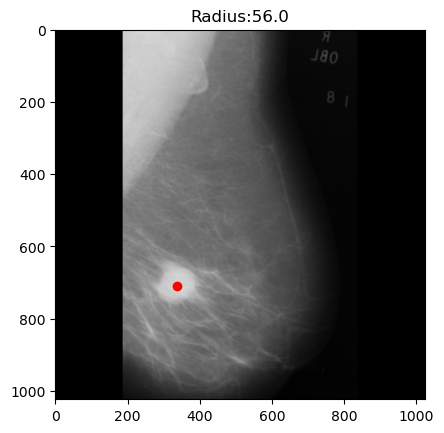

In [6]:
def draw_image_mias(df: pd.DataFrame, idx: int) -> None:
    ''' draw image with location of center of abnormality '''
    img = cv2.imread(df['image_path'][idx])
    plt.imshow(img, cmap='gray')

    #  account for horizontal flip of some images
    if idx % 2 == 0:
        x_loc = df.x_center_abnormality[idx]
    else:
        print(df.x_center_abnormality[idx])
        x_loc = 1024 - df.x_center_abnormality[idx]
    plt.plot([x_loc], [1024-df.y_center_abnormality[idx]], 'ro')
    radius = str(df.radius[idx]) if df.radius[idx] != 'nan' else "N/A"
    plt.title("Radius:" + radius)
    plt.show()
    
draw_image_mias(df_mias, IDX_MIAS)

### INBREAST

##### Variáveis base

In [7]:
df_inbreast = pd.read_csv('../../outputs/mamografia/inbreast/metadata_inbreast.csv')

IDX_INBREAST = 1

IMAGE_INBREAST = dcmread(df_inbreast['image_path'][IDX_INBREAST]).pixel_array
IMAGE_INBREAST = ((IMAGE_INBREAST / IMAGE_INBREAST.max()) * 255).astype('uint8')

ROI_IMAGE_INBREAST = load_inbreast_mask(df_inbreast['roi_image_path'][IDX_INBREAST]).astype(np.uint8)

##### Equalização de histograma

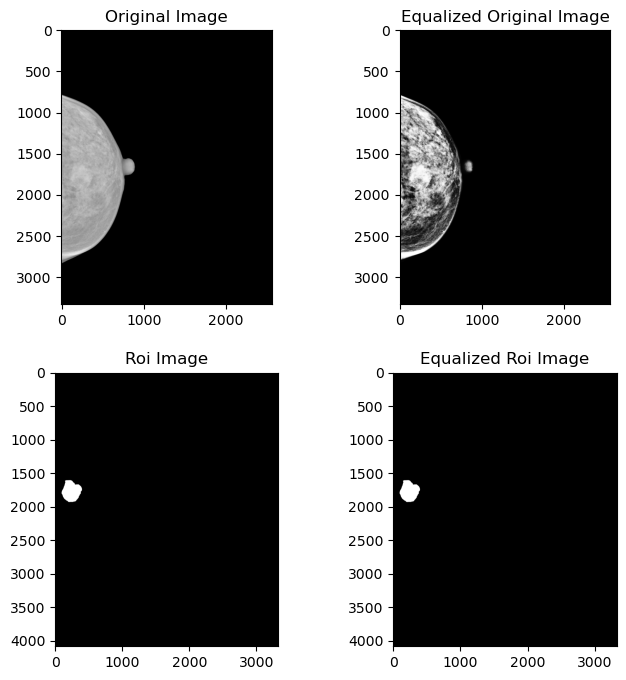

In [8]:
equalized_image = cv2.equalizeHist(IMAGE_INBREAST)
equalized_roi_image = cv2.equalizeHist(ROI_IMAGE_INBREAST)

images = [IMAGE_INBREAST, equalized_image, ROI_IMAGE_INBREAST, equalized_roi_image]
titles = ['Original Image', 'Equalized Original Image', 'Roi Image', 'Equalized Roi Image']

fig = plt.figure(figsize=(8, 8))

for i in range(len(images)):
    plt.subplot(2, 2, i + 1)
    plt.title(titles[i])
    plt.imshow(images[i], cmap='gray')

# Adiciona margem entre as subplots
plt.subplots_adjust(hspace = 0.25)
plt.show()

##### Clahe

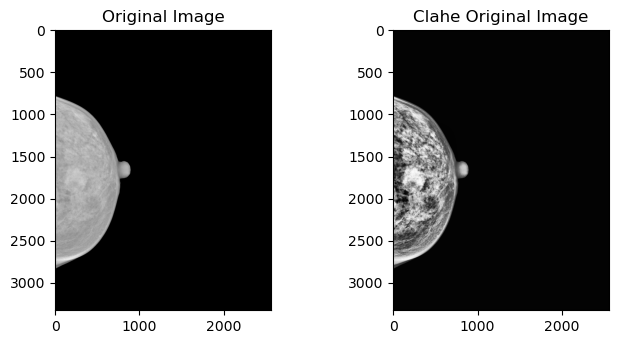

In [9]:
clahe_image = equalize_adapthist(IMAGE_INBREAST, clip_limit=0.03)
#image_clahe = cv2.createCLAHE(clipLimit=6, tileGridSize=(8, 8)).apply(IMAGE_CROPPED)

clahe_image = clahe_image * 255

""" image_clahe[image_clahe > 220] = 255
image_clahe[image_clahe < 220] = 0"""

fig = plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.title('Original Image')
plt.imshow(IMAGE_INBREAST, cmap='gray')

plt.subplot(2, 2, 2)
plt.title('Clahe Original Image')
plt.imshow(clahe_image, cmap='gray')

# Adiciona margem entre as subplots
plt.subplots_adjust(hspace = 0.2)
plt.show()

### CMMD

##### Variável base

In [10]:
df_cmmd = pd.read_csv('../../outputs/mamografia/cmmd/metadata_cmmd.csv')

IDX_CMMD = 0

IMAGE_CMMD = dcmread(df_cmmd['image_path'][IDX_CMMD]).pixel_array
IMAGE_CMMD = ((IMAGE_CMMD / IMAGE_CMMD.max()) * 255).astype('uint8')

##### Equalização de histograma

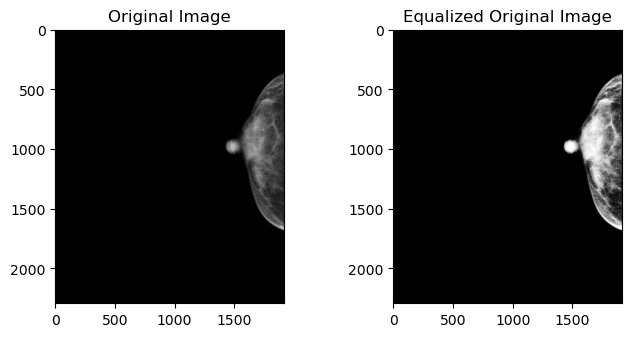

In [11]:
equalized_image = cv2.equalizeHist(IMAGE_CMMD)

images = [IMAGE_CMMD, equalized_image]
titles = ['Original Image', 'Equalized Original Image']

fig = plt.figure(figsize=(8, 8))

for i in range(len(images)):
    plt.subplot(2, 2, i + 1)
    plt.title(titles[i])
    plt.imshow(images[i], cmap='gray')

# Adiciona margem entre as subplots
plt.subplots_adjust(hspace = 0.25)
plt.show()

##### CLAHE

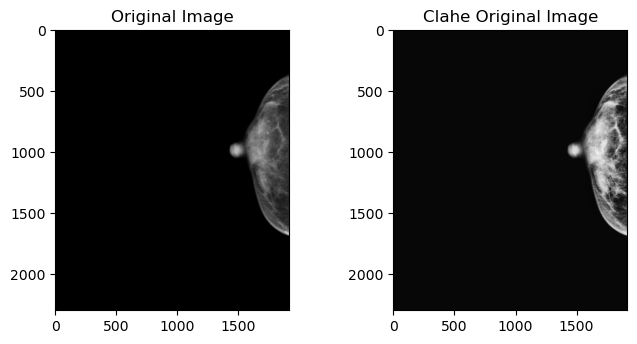

In [12]:
clahe_image = equalize_adapthist(IMAGE_CMMD, clip_limit=0.03)
clahe_image = clahe_image * 255
clahe_image = clahe_image.astype(np.uint8)

fig = plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.title('Original Image')
plt.imshow(IMAGE_CMMD, cmap='gray')

plt.subplot(2, 2, 2)
plt.title('Clahe Original Image')
plt.imshow(clahe_image, cmap='gray')

# Adiciona margem entre as subplots
plt.subplots_adjust(hspace = 0.2)
plt.show()

##### Segmentação

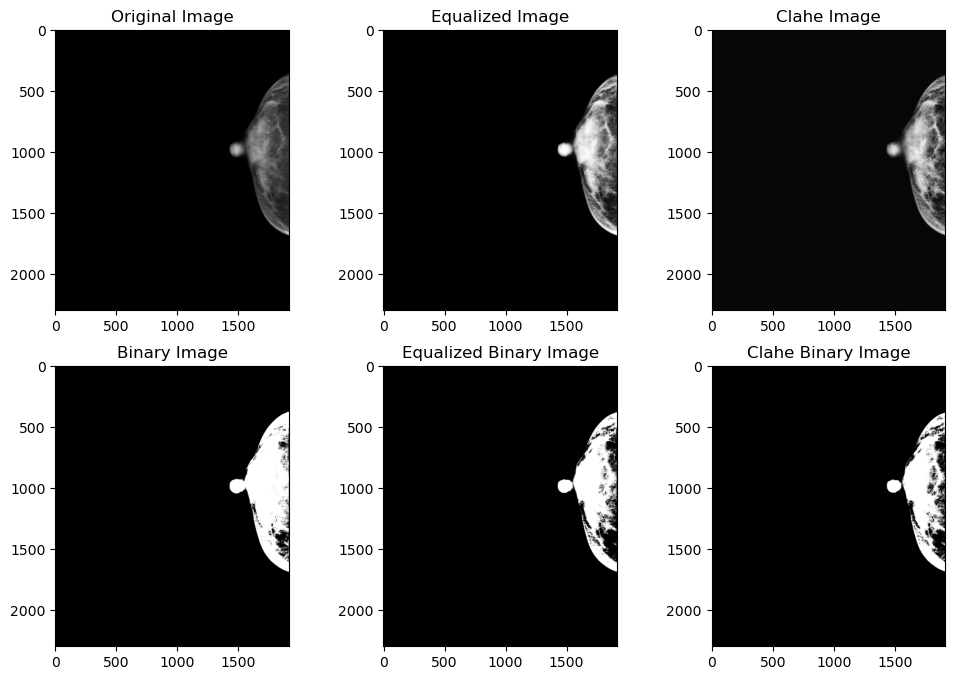

In [13]:
equalized_binary_image = cv2.threshold(equalized_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
binary_image = cv2.threshold(IMAGE_CMMD, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
clahe_binary_image = cv2.threshold(clahe_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

images = [IMAGE_CMMD, equalized_image, clahe_image,
          binary_image, equalized_binary_image, clahe_binary_image]
titles = ['Original Image', 'Equalized Image', 'Clahe Image',
          'Binary Image', 'Equalized Binary Image', 'Clahe Binary Image']

plt.figure(figsize=(12, 8))
for i in range(len(images)):
    plt.subplot(2, 3, i + 1)
    plt.title(titles[i])
    plt.imshow(images[i], cmap='gray')

# Adiciona margem entre as subplots
plt.subplots_adjust(hspace = 0.2)
plt.show()